In [1]:
import numpy as np
import math
import GPy
import matplotlib.pyplot as plt
import seaborn

In [2]:
from scipy.stats import qmc

# Goldstein-Price function (as defined in previous responses)
def goldstein_price(data):
    x = data[0]
    y = data[1]
    val1 = (1 + (x+y+1)**2 * (19-14*x+3*x**2-14*y+6*x*y+3*y**2))
    val2 = (30 + ((2*x-3*y)**2) * (18-32*x+12*x**2+48*y-36*x*y+27*y**2))
    return math.log(val1 * val2)


# Dimensionality of the problem
d = 2  # For Goldstein-Price (x1 and x2)

# Number of samples
n_samples = 32

# Create a Sobol sequence generator
sobol_engine = qmc.Sobol(d=d, scramble=False)  # scramble=True for better properties in high dimensions

# Generate Sobol points
sobol_points = sobol_engine.random_base2(m=int(np.log2(n_samples)))


# If n_samples is not a power of 2: (important!)
if not (n_samples != 0 and (n_samples & (n_samples - 1) == 0)): # Check if n_samples is not a power of 2
    sobol_points = sobol_engine.random(n=n_samples) #use random if not power of two


# Scale and shift to the Goldstein-Price domain [-2, 2]
domain_min = -2
domain_max = 2
scaled_sobol_points = domain_min + (domain_max - domain_min) * sobol_points
# Evaluate the function
function_values = np.array([goldstein_price(point) for point in scaled_sobol_points])

In [3]:
def fit_gaussian_gpy(X, y):
    k = GPy.kern.RBF(input_dim=X.shape[1], variance=1.0, lengthscale=1.0)  
    mean = GPy.mappings.Constant(input_dim = X.shape[1], output_dim = 1, value = np.mean(y))
    model = GPy.models.GPRegression(X, y, k, noise_var=0.001**2, mean_function=mean)

    model.Gaussian_noise.variance.fix()
    #model.kern.lengthscale.constrain_bounded(1e-15, 1e15)
    #model.kern.variance.constrain_bounded(1e-20, 1e20)  # Constrain variance of RBF

    model.optimize_restarts(100, verbose=False)  

    print(model)  
    n = model.num_data
    k = len(model.parameters)
    log_likelihood = model.log_likelihood()
    
    bic = k * np.log(n) - 2 * log_likelihood

    return model

In [4]:
model = fit_gaussian_gpy(scaled_sobol_points, function_values.reshape(-1, 1))


Name : GP regression
Objective : 64.20627488842976
Number of Parameters : 4
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  constmap.C               |    9.161737078938751  |               |        
  rbf.variance             |     5.13555357849638  |      +ve      |        
  rbf.lengthscale          |  0.46968692947858615  |      +ve      |        
  Gaussian_noise.variance  |                1e-06  |   +ve fixed   |        


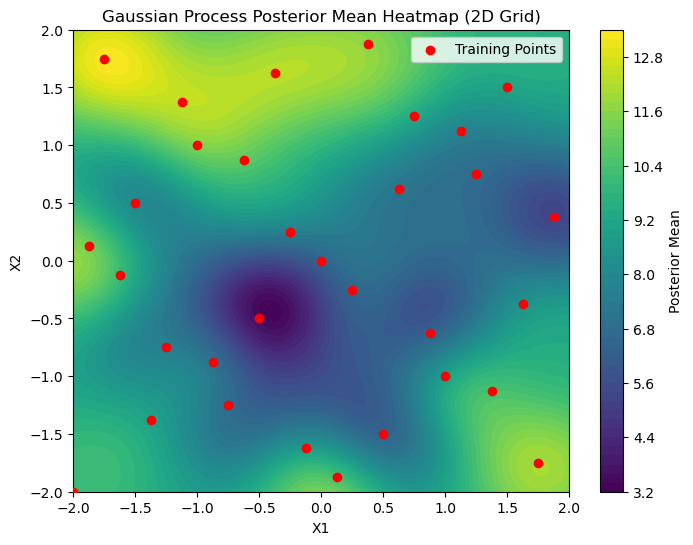

In [5]:
x1_grid = np.linspace(-2, 2, 1000)
x2_grid = np.linspace(-2, 2, 1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
X_grid = np.vstack((X1.ravel(), X2.ravel())).T  # Reshape into a 2D array (1000000, 2)
# Make predictions (posterior mean and variance) on the grid
y_pred, y_var = model.predict(X_grid)
y_std = np.sqrt(y_var)
# Reshape the predictions back to the grid shape
y_pred_grid = y_pred.reshape(1000, 1000)

# Plot the posterior mean as a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, y_pred_grid, 50, cmap="viridis")
plt.colorbar(label='Posterior Mean')
plt.scatter(scaled_sobol_points[:, 0], scaled_sobol_points[:, 1], color='red', zorder=10, label='Training Points')
plt.title("Gaussian Process Posterior Mean Heatmap (2D Grid)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

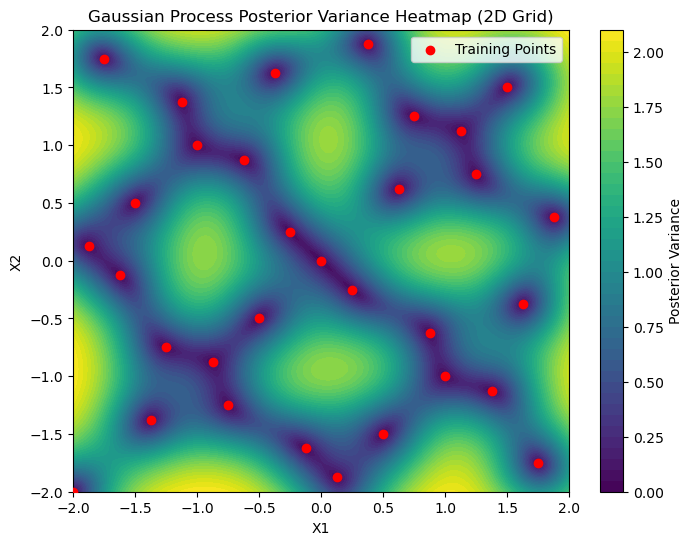

In [6]:
y_std_grid = y_std.reshape(1000, 1000)
# Plot the posterior mean as a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, y_std_grid, 50, cmap="viridis")
plt.colorbar(label='Posterior Variance')
plt.scatter(scaled_sobol_points[:, 0], scaled_sobol_points[:, 1], color='red', zorder=10, label='Training Points')
plt.title("Gaussian Process Posterior Variance Heatmap (2D Grid)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

In [7]:
all_fxn_values = np.array([goldstein_price(point) for point in X_grid]).reshape(-1, 1)



In [8]:
diff = np.subtract(all_fxn_values, y_pred)
res = np.divide(diff, y_std).flatten()
print(res.shape)

(1000000,)


In [9]:
from scipy.stats import gaussian_kde
kde = gaussian_kde(res)

In [10]:
x_grid = np.linspace(np.min(res)-1, np.max(res)+1, 1000) 

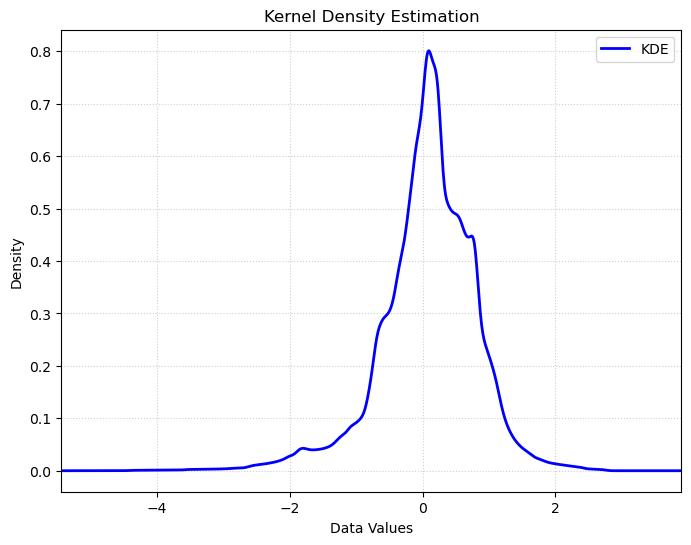

In [11]:
kde_values = kde(x_grid)

# 5. Visualization
plt.figure(figsize=(8, 6))

# Plot the KDE
plt.plot(x_grid, kde_values, label='KDE', color='blue', linewidth=2)
plt.title('Kernel Density Estimation')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.legend()

# Customize the plot (optional)
plt.grid(True, linestyle=':', alpha=0.6)  # Add a grid
plt.xlim([np.min(res)-1, np.max(res)+1])

# Show the plot
plt.show()